In [304]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

main_path = './artists/'

img_size = (128, 128)
batch_size = 128

In [305]:
from keras.utils import image_dataset_from_directory


Xtrain = image_dataset_from_directory(main_path, 
                                      subset='training', 
                                      validation_split=0.2,
                                      image_size=img_size,
                                      batch_size=batch_size,
                                      seed=123)

Xval = image_dataset_from_directory(main_path,
                                    subset='validation',
                                    validation_split=0.2,
                                    image_size=img_size,
                                    batch_size=batch_size,
                                    seed=123)

Xtest = image_dataset_from_directory('./test',
                                     image_size=img_size,
                                     batch_size=batch_size,
                                     shuffle=False)


classes = Xtrain.class_names
print(classes)

Found 760 files belonging to 5 classes.
Using 608 files for training.
Found 760 files belonging to 5 classes.
Using 152 files for validation.
Found 120 files belonging to 5 classes.
['AndyWarhol', 'PabloPicasso', 'Rembrant', 'SalvadorDali', 'VincentVanGogh']


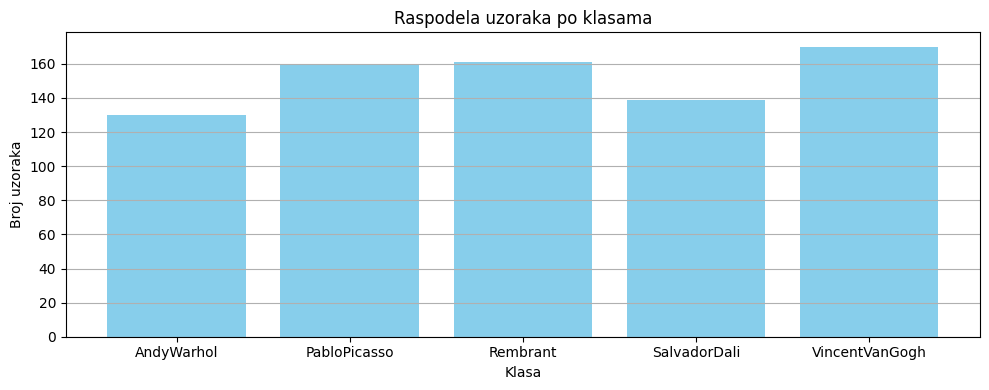

In [306]:
import os

plt.figure(figsize=(10, 4))

class_counts = [len([
    f for f in os.listdir(os.path.join(main_path, cls)) 
    if os.path.isfile(os.path.join(main_path, cls, f))
]) for cls in classes]

plt.bar(classes, class_counts, color='skyblue')
plt.xlabel('Klasa')
plt.ylabel('Broj uzoraka')
plt.title('Raspodela uzoraka po klasama')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

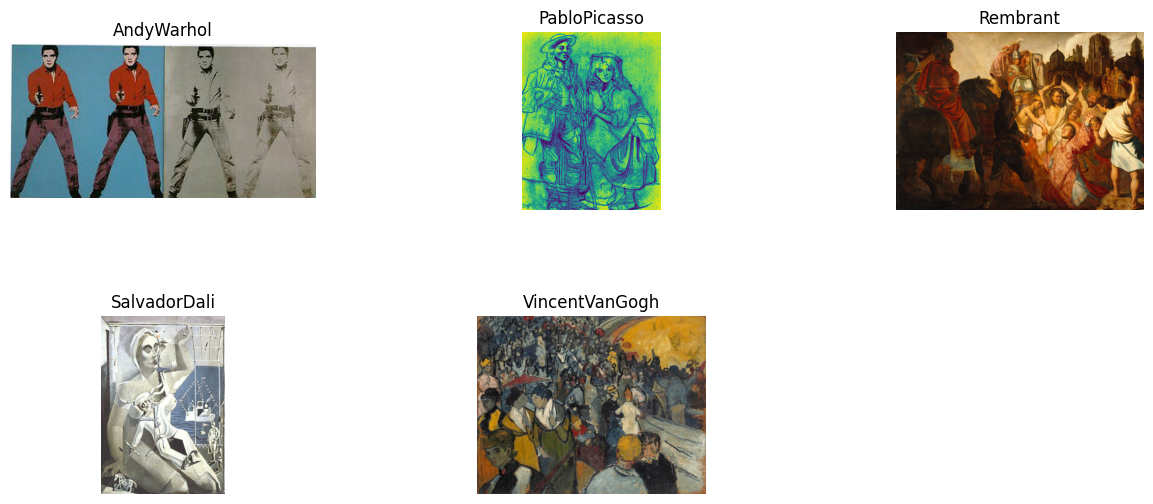

In [307]:
from PIL import Image

images_per_class = []

for class_name in classes:
    class_folder = os.path.join(main_path, class_name)
    
    # List all files in the class folder
    image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        first_image_path = os.path.join(class_folder, image_files[0])
        img = Image.open(first_image_path)
        images_per_class.append((class_name, img))
    else:
        print(f"No image files found in {class_name}")

# Plotting
N = len(images_per_class)
plt.figure(figsize=(15, 6))

for i, (class_name, img) in enumerate(images_per_class):
    plt.subplot(2, int((N + 1) / 2), i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

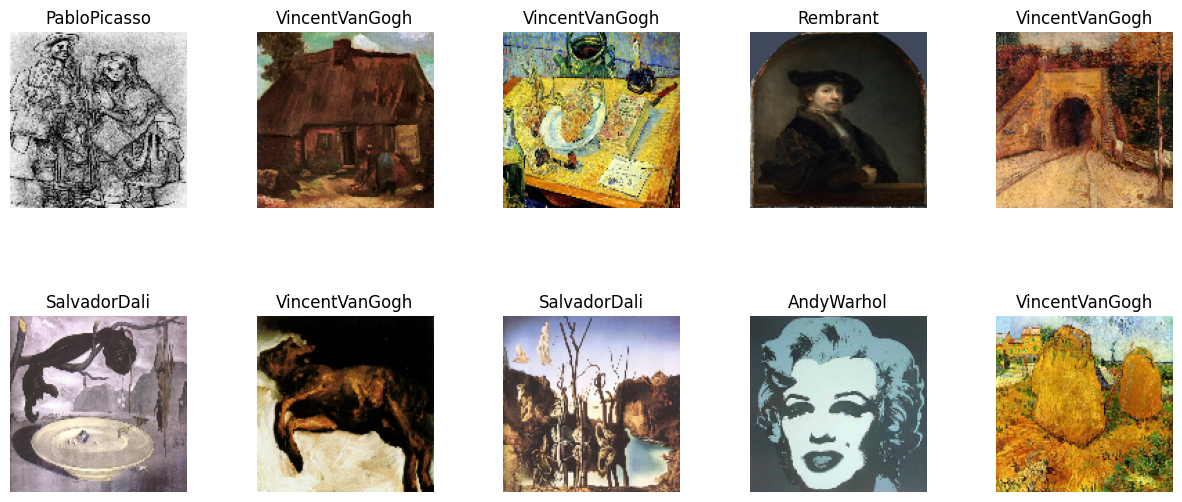

In [308]:
import matplotlib.pyplot as plt

N = 10

plt.figure(figsize=(15, 6))
for img, lab in Xtrain.take(1):
    for i in range(N):
        plt.subplot(2, int(N/2), i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes[lab[i]])
        plt.axis('off')

#plt.tight_layout(pad=3.0)  
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.show()

In [309]:
from keras import layers
from keras import Sequential

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_size[0], 
                                                 img_size[1], 3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1),
  ]
)

D:\Downloads\Python\Neuralne\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


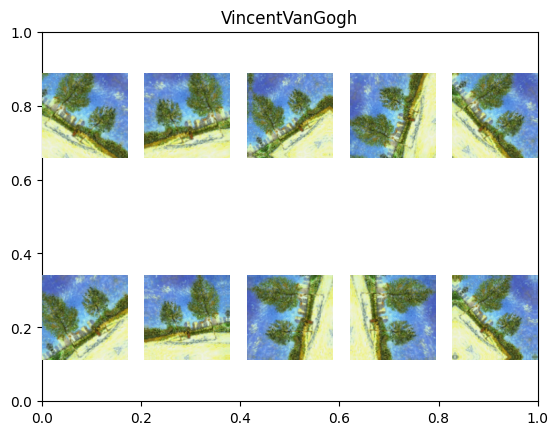

In [310]:
N = 10

plt.figure()
for img, lab in Xtrain.take(1):
    plt.title(classes[lab[0]])
    for i in range(N):
        aug_img = data_augmentation(img)
        plt.subplot(2, int(N/2), i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')
        

In [311]:
from keras import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy  

num_classes = len(classes)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_32 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,965 (32.09 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.src.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor='val_loss', 
                           patience=10, 
                           restore_best_weights=True)

history = model.fit(Xtrain,
                    epochs=100,
                    callbacks=[stop_early],
                    validation_data=Xval,
                    verbose=0)

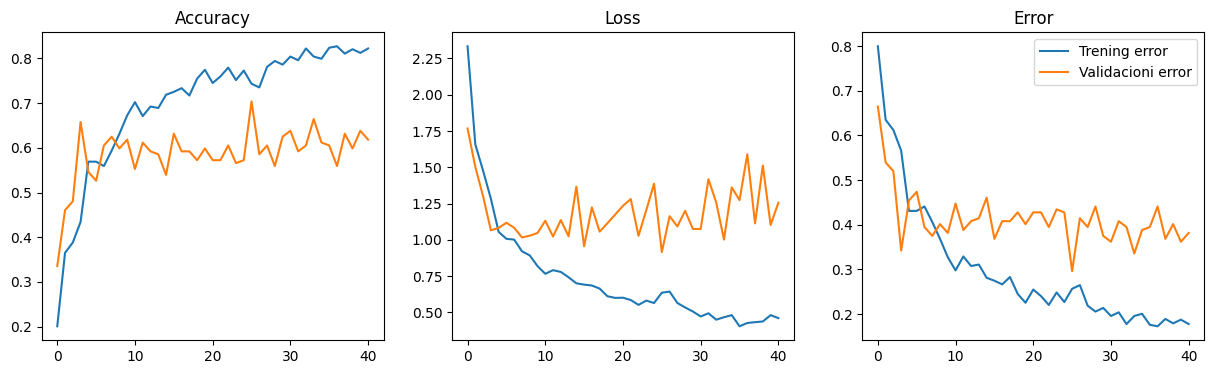

In [319]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.subplot(1,3,2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')


train_error = [1 - acci for acci in acc]
val_error = [1 - acci for acci in val_acc]

plt.subplot(1,3,3)
plt.plot(train_error, label='Trening error')
plt.plot(val_error, label='Validacioni error')
plt.title('Error')

plt.legend()

In [320]:
labels = np.array([])
pred = np.array([])
for img, lab in Xtrain.take(1):
    labels = np.append(labels, lab)
    pred = np.append(pred, np.argmax(model.predict(img, verbose=0), axis=1))  

Tačnost modela je: 77.34375%


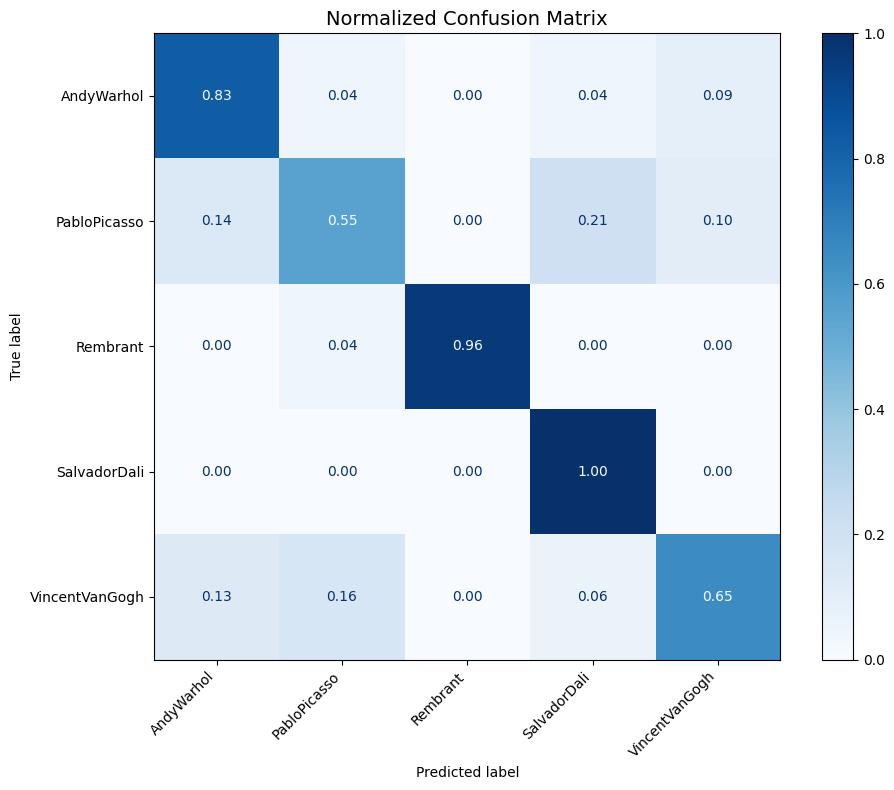

In [321]:
from sklearn.metrics import accuracy_score
print('Tačnost modela je: ' + str(100*accuracy_score(labels, pred)) + '%')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, pred, normalize='true')
plt.figure(figsize=(10, 8))  # Adjust size as needed

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot(cmap=plt.cm.Blues, values_format=".2f", ax=plt.gca())  # Format with 2 decimals

plt.title("Normalized Confusion Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [322]:
labels = np.array([])
pred = np.array([])
for img, lab in Xtest.take(1):
    labels = np.append(labels, lab)
    pred = np.append(pred, np.argmax(model.predict(img, verbose=0), axis=1))  

Tačnost modela je: 78.33333333333333%


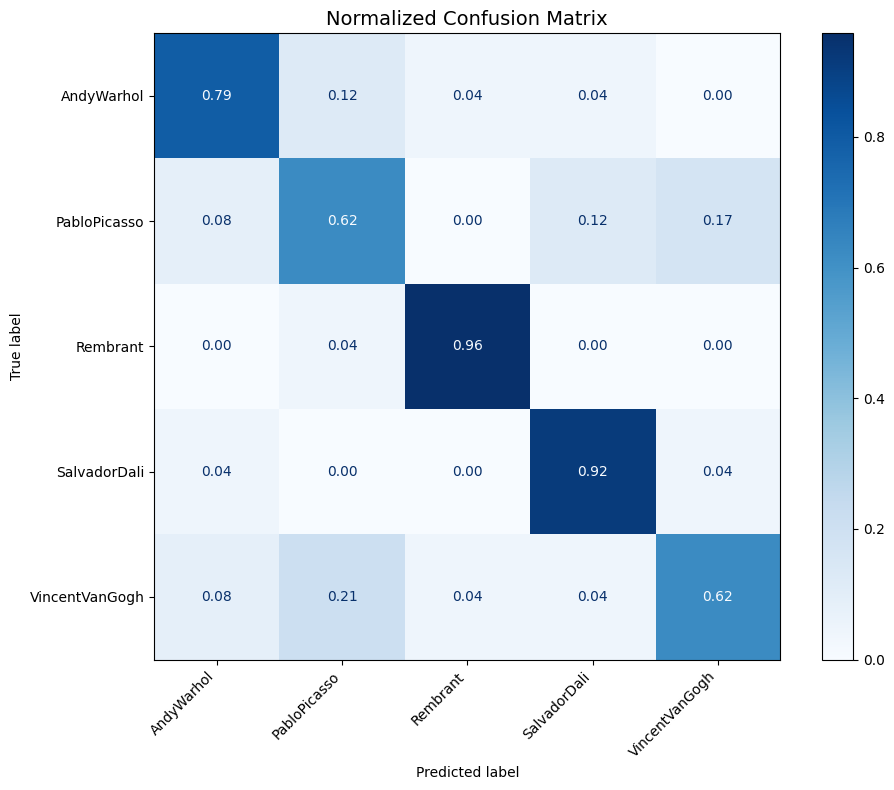

In [323]:
from sklearn.metrics import accuracy_score
print('Tačnost modela je: ' + str(100*accuracy_score(labels, pred)) + '%')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, pred, normalize='true')
plt.figure(figsize=(10, 8))  # Adjust size as needed

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot(cmap=plt.cm.Blues, values_format=".2f", ax=plt.gca())  # Format with 2 decimals

plt.title("Normalized Confusion Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [324]:
def print_metrics_from_cm(cm, class_labels):
    n_classes = len(class_labels)
    for i in range(n_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        accuracy = (TP + TN) / cm.sum() if cm.sum() > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\nKlasa '{class_labels[i]}':")
        print(f"  Tačnost: {accuracy:.3f}")
        print(f"  Preciznost: {precision:.3f}")
        print(f"  Osetljivost: {recall:.3f}")
        print(f"  F1-skor: {f1:.3f}")

class_labels = classes
print_metrics_from_cm(cm, class_labels)


Klasa 'AndyWarhol':
  Tačnost: 0.917
  Preciznost: 0.792
  Osetljivost: 0.792
  F1-skor: 0.792

Klasa 'PabloPicasso':
  Tačnost: 0.850
  Preciznost: 0.625
  Osetljivost: 0.625
  F1-skor: 0.625

Klasa 'Rembrant':
  Tačnost: 0.975
  Preciznost: 0.920
  Osetljivost: 0.958
  F1-skor: 0.939

Klasa 'SalvadorDali':
  Tačnost: 0.942
  Preciznost: 0.815
  Osetljivost: 0.917
  F1-skor: 0.863

Klasa 'VincentVanGogh':
  Tačnost: 0.883
  Preciznost: 0.750
  Osetljivost: 0.625
  F1-skor: 0.682
